In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.special import expit, logit  # inv.logit is expit in Python; logit is its inverse function
from scipy.stats import norm, t as student_t
import statsmodels.api as sm
import re

## Creating Stan Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install cmdstanpy
!python -m cmdstanpy.install_cmdstan

<frozen runpy>:128: RuntimeWarning: 'cmdstanpy.install_cmdstan' found in sys.modules after import of package 'cmdstanpy', but prior to execution of 'cmdstanpy.install_cmdstan'; this may result in unpredictable behaviour
CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /tmp/tmpd1hvl0tn
Extracting distribution
Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.
Installed cmdstan-2.36.0
Test model compilation


In [ ]:
from cmdstanpy import CmdStanModel
import os

# Ignore this -- todo: port stan code from the github (more complicated than the linzer model)
# Rewrite the provided Stan code with anchored delta[J] using transformed parameters

stan_code = """
data {
  int<lower=1> K;                    // number of polls
  int<lower=1> J;                    // number of campaign days
  int<lower=1> S;                    // number of states
  array[K] int<lower=1, upper=S> state; // state for each poll
  array[K] int<lower=1, upper=J> day;   // day for each poll
  array[K] int<lower=0> n;               // sample size of poll
  array[K] int<lower=0> y;               // number of dem supporters
  vector[S] h;                        // historical forecasts (h_i)
  vector[S] tau;                      // prior precision for each state (tau_i)
}
parameters {
  matrix[S, J] beta;                 // state-level support over time
  vector[J - 1] delta_raw;           // free parameters for national swing (J-1 values)
  real<lower=0> sigma_beta;          // variance of beta
  real<lower=0> sigma_delta;         // variance of delta
}
transformed parameters {
  vector[J] delta;
  for (j in 1:(J - 1))
    delta[j] = delta_raw[j];
  delta[J] = 0;  // anchor on Election Day
}
model {
  // Priors on beta and delta (reverse random walk from election day J)
  for (s in 1:S)
    beta[s, J] ~ normal(logit(h[s]), inv(sqrt(tau[s])));

  for (j in 1:(J - 1)) {
    for (s in 1:S)
      beta[s, j] ~ normal(beta[s, j + 1], sigma_beta);
    delta_raw[j] ~ normal(delta[j + 1], sigma_delta);
  }

  // Likelihood: poll observations
  for (k in 1:K) {
    real logit_pi = beta[state[k], day[k]] + delta[day[k]];
    y[k] ~ binomial_logit(n[k], logit_pi);
  }

  // Hyperpriors
  sigma_beta ~ uniform(0, 1);
  sigma_delta ~ uniform(0, 1);
}
generated quantities {
  matrix[S, J] pi;
  for (s in 1:S)
    for (j in 1:J)
      pi[s, j] = inv_logit(beta[s, j] + delta[j]);
}
"""

model_path = "/content/drive/MyDrive/poll_model.stan"
with open(model_path, "w") as f:
    f.write(stan_code)

model = CmdStanModel(stan_file=model_path)

DEBUG:cmdstanpy:Removing /content/drive/MyDrive/poll_model
17:37:52 - cmdstanpy - INFO - compiling stan file /content/drive/MyDrive/poll_model.stan to exe file /content/drive/MyDrive/poll_model
INFO:cmdstanpy:compiling stan file /content/drive/MyDrive/poll_model.stan to exe file /content/drive/MyDrive/poll_model
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=poll_model.stan /content/drive/MyDrive/poll_model
cwd: /root/.cmdstan/cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=poll_model.stan --o=/content/drive/MyDrive/poll_model.hpp /content/drive/MyDrive/poll_model.stan

--- Compiling C++ code ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boos

# Test Stan model on generated data

In [ ]:
import numpy as np

# Shared setup
np.random.seed(0)
S = 5       # number of states
J = 100      # number of days
K = int(2000/(12 * 30 * 50) * S * J)  # total polls per dataset -- match with Linzer? 2000 polls in 12 months for 50 states => 0.1 polls per state per day

tau = 5 * np.ones(S)
h = np.random.uniform(0.4, 0.6, size=S) # randomly set the final vote shares for each of the states
true_sigma_beta = 0.1
true_sigma_delta = 0.05

# Reverse random walk from election day
beta = np.zeros((S, J))
delta = np.zeros(J)
beta[:, -1] = np.random.normal(np.log(h / (1 - h)), 1 / np.sqrt(tau))
delta[-1] = 0  # anchor national support on election day

for j in reversed(range(J - 1)):
    beta[:, j] = beta[:, j + 1] + np.random.normal(0, true_sigma_beta, size=S)
    delta[j] = delta[j + 1] + np.random.normal(0, true_sigma_delta)

# TODO: Make another dataset using Linzer's assumptions (the number of polls increases closer to election day, and more polls in swing states)
# Dataset 1: all states well-polled
polls_per_state_1 = np.random.multinomial(K, [1 / S] * S)
state_idx_1, day_idx_1, n1 = [], [], []
for s in range(S):
    state_idx_1.extend([s] * polls_per_state_1[s])
    day_idx_1.extend(np.random.randint(0, J, size = polls_per_state_1[s]))
    n1.extend(np.random.randint(400, 1000, size = polls_per_state_1[s]))

state_idx_1 = np.array(state_idx_1)
day_idx_1 = np.array(day_idx_1)
logit_pi_1 = beta[state_idx_1, day_idx_1] + delta[day_idx_1]
pi_1 = 1 / (1 + np.exp(-logit_pi_1))
y1 = np.random.binomial(n1, pi_1)

test_data_1 = {
    "K": K,
    "J": J,
    "S": S,
    "state": (state_idx_1 + 1).tolist(),  # Stan uses 1-based indexing
    "day": (day_idx_1 + 1).tolist(),
    "n": list(n1),
    "y": y1.tolist(),
    "h": h.tolist(),
    "tau": tau.tolist(),
}

# Dataset 2: Some well-polled (states 0, 1, 2) and sparsely-polled (states 3, 4) states
sparse_states = [3, 4]
polls_sparse = max(1, int(K / (S * 3)))
polls_sparse_total = polls_sparse * len(sparse_states)
polls_remaining = K - polls_sparse_total

# Allocate remaining polls to well-polled states
allocated = np.random.multinomial(polls_remaining, [1 / 3] * 3)
polls_per_state_2 = {
    0: allocated[0],
    1: allocated[1],
    2: allocated[2],
    3: polls_sparse,
    4: polls_sparse,
}

state_idx_2, day_idx_2, n2 = [], [], []
for s in range(S):
    num_polls = polls_per_state_2[s]
    state_idx_2.extend([s] * num_polls)
    day_idx_2.extend(np.random.randint(0, J, size=num_polls))
    n2.extend(np.random.randint(400, 1000, size=num_polls))

state_idx_2 = np.array(state_idx_2)
day_idx_2 = np.array(day_idx_2)
logit_pi_2 = beta[state_idx_2, day_idx_2] + delta[day_idx_2]
pi_2 = 1 / (1 + np.exp(-logit_pi_2))
y2 = np.random.binomial(n2, pi_2)

test_data_2 = {
    "K": K,
    "J": J,
    "S": S,
    "state": (state_idx_2 + 1).tolist(),
    "day": (day_idx_2 + 1).tolist(),
    "n": list(n2),
    "y": y2.tolist(),
    "h": h.tolist(),
    "tau": tau.tolist(),
}

# Summary of poll allocation
import pandas as pd
poll_summary = pd.DataFrame({
    "State": [f"State {s}" for s in range(S)],
    "Dataset 1 (Well-Polled)": polls_per_state_1,
    "Dataset 2 (Sparse 3, Others Heavy)": [polls_per_state_2[s] for s in range(S)],
})
print(poll_summary)

     State  Dataset 1 (Well-Polled)  Dataset 2 (Sparse 3, Others Heavy)
0  State 0                        9                                  20
1  State 1                       12                                  15
2  State 2                        8                                  14
3  State 3                       18                                   3
4  State 4                        8                                   3


In [ ]:
fit_1 = model.sample(data=test_data_1, chains=4, iter_sampling=500, iter_warmup=500)
fit_2 = model.sample(data=test_data_2, chains=4, iter_sampling=500, iter_warmup=500)

DEBUG:cmdstanpy:cmd: /content/drive/MyDrive/poll_model info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp72ivarxk/wa87xoc_.json
17:38:20 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=35457', 'data', 'file=/tmp/tmp72ivarxk/wa87xoc_.json', 'output', 'file=/tmp/tmp72ivarxk/poll_model2jn99_bp/poll_model-20250506173820_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=2', 'random', 'seed=35457', 'data', 'file=/tmp/tmp72ivarxk/wa87xoc_.json', 'output', 'file=/tmp/tmp72ivarxk/poll_model2jn99_bp/poll_model-20250506173820_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=3', 'random', 'seed=35457', 'data', 'file=/tmp/tmp72ivarxk/wa87xoc

17:38:26 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=35457', 'data', 'file=/tmp/tmp72ivarxk/wa87xoc_.json', 'output', 'file=/tmp/tmp72ivarxk/poll_model2jn99_bp/poll_model-20250506173820_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp72ivarxk/poll_model2jn99_bp/poll_model-20250506173820_1.csv
 console_msgs (if any):
	/tmp/tmp72ivarxk/poll_model2jn99_bp/poll_model-20250506173820_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Def

17:38:26 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 500 divergent transitions (100.0%)
	Chain 2 had 500 divergent transitions (100.0%)
	Chain 3 had 500 divergent transitions (100.0%)
	Chain 4 had 500 divergent transitions (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 500 divergent transitions (100.0%)
	Chain 2 had 500 divergent transitions (100.0%)
	Chain 3 had 500 divergent transitions (100.0%)
	Chain 4 had 500 divergent transitions (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
DEBUG:cmdstanpy:cmd: /content/drive/MyDrive/poll_model info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp72ivarxk/3zhdnihn.json
17:38:26 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=17600', 'data', 'file=/tmp/tmp72ivarxk/3zhdnihn.json', 'output', 'file=/tmp/tmp72ivarxk/poll_modelrbogn7p1/poll_model-20250506173826_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=2', 'random', 'seed=17600', 'data', 'file=/tmp/tmp72ivarxk/3zhdnihn.json', 'output', 'file=/tmp/tmp72ivarxk/poll_modelrbogn7p1/poll_model-20250506173826_2.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/drive/MyDrive/poll_model', 'id=3', 'random', 'seed=17600', 'data', 'file=/tmp/tmp72ivarxk/3zhdnih

17:38:37 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/drive/MyDrive/poll_model', 'id=1', 'random', 'seed=17600', 'data', 'file=/tmp/tmp72ivarxk/3zhdnihn.json', 'output', 'file=/tmp/tmp72ivarxk/poll_modelrbogn7p1/poll_model-20250506173826_1.csv', 'method=sample', 'num_samples=500', 'num_warmup=500', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp72ivarxk/poll_modelrbogn7p1/poll_model-20250506173826_1.csv
 console_msgs (if any):
	/tmp/tmp72ivarxk/poll_modelrbogn7p1/poll_model-20250506173826_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 500
    num_warmup = 500
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Def

17:38:37 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 500 divergent transitions (100.0%)
	Chain 2 had 500 divergent transitions (100.0%)
	Chain 3 had 500 divergent transitions (100.0%)
	Chain 4 had 500 divergent transitions (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.
	Chain 1 had 500 divergent transitions (100.0%)
	Chain 2 had 500 divergent transitions (100.0%)
	Chain 3 had 500 divergent transitions (100.0%)
	Chain 4 had 500 divergent transitions (100.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


<ipython-input-8-b6197704658c>:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_well = cm.get_cmap("tab10")
<ipython-input-8-b6197704658c>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_sparse = cm.get_cmap("Set2")


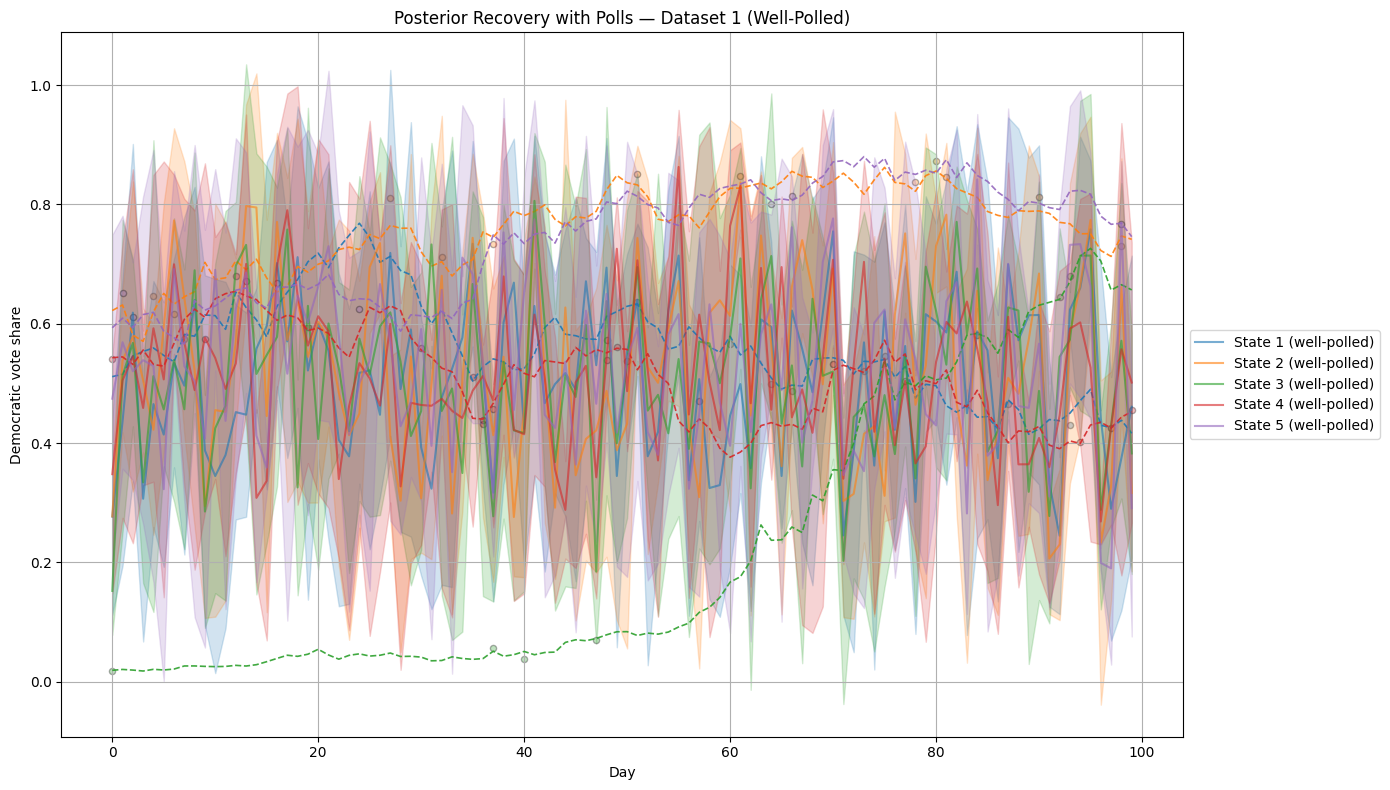


Election Day Comparison — Dataset 1 (Well-Polled)
State 1: True = 0.416, Predicted = 0.461
State 2: True = 0.741, Predicted = 0.316
State 3: True = 0.657, Predicted = 0.383
State 4: True = 0.453, Predicted = 0.501
State 5: True = 0.746, Predicted = 0.291


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import arviz as az

def plot_recovery_with_polls(
    fit, beta, delta, dataset_name, well_polled_states, sparse_states, poll_data
):
    pi_samples = fit.stan_variable("pi")  # shape: [draws, S, J]
    mean_pi = np.mean(pi_samples, axis=0)
    std_pi = np.std(pi_samples, axis=0)
    true_pi = 1 / (1 + np.exp(-(beta + delta[np.newaxis, :])))  # shape: (S, J)

    state_idx = np.array(poll_data["state"]) - 1
    day_idx = np.array(poll_data["day"]) - 1
    n = np.array(poll_data["n"])
    y = np.array(poll_data["y"])
    poll_pi = y / n

    # Colormaps
    cmap_well = cm.get_cmap("tab10")
    cmap_sparse = cm.get_cmap("Set2")

    plt.figure(figsize=(14, 8))
    for s in range(S):
        if s in well_polled_states:
            base_color = cmap_well(s % 10)
            label = f"State {s+1} (well-polled)"
        else:
            base_color = cmap_sparse(s % 8)
            label = f"State {s+1} (sparse)"

        # True and posterior
        darker_color = mcolors.to_rgba(base_color, alpha=0.9)
        lighter_color = mcolors.to_rgba(base_color, alpha=0.6)

        plt.plot(true_pi[s], '--', linewidth=1.2, color=darker_color)
        plt.plot(mean_pi[s], label=label, color=lighter_color)
        plt.fill_between(
            np.arange(J),
            mean_pi[s] - std_pi[s],
            mean_pi[s] + std_pi[s],
            color=lighter_color,
            alpha=0.2
        )

        # Polls
        poll_mask = (state_idx == s)
        plt.scatter(
            day_idx[poll_mask],
            poll_pi[poll_mask],
            color=base_color,
            alpha=0.3,
            edgecolor='k',
            s=20,
        )

    plt.xlabel("Day")
    plt.ylabel("Democratic vote share")
    plt.title(f"Posterior Recovery with Polls — {dataset_name}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Final-day comparison
    true_final_probs = 1 / (1 + np.exp(-(beta[:, -1] + delta[-1])))
    pred_final_probs = mean_pi[:, -1]
    print(f"\nElection Day Comparison — {dataset_name}")
    for s in range(S):
        print(f"State {s+1}: True = {true_final_probs[s]:.3f}, Predicted = {pred_final_probs[s]:.3f}")

    # Trace plots
    idata = az.from_cmdstanpy(posterior=fit)
    az.plot_trace(idata, var_names=["sigma_beta", "sigma_delta"])
    plt.suptitle(f"Trace Plots for {dataset_name}", y=1.02)
    plt.tight_layout()
    plt.show()

plot_recovery_with_polls(
    fit_1, beta, delta, "Dataset 1 (Well-Polled)",
    well_polled_states=[0, 1, 2, 3, 4], sparse_states=[],
    poll_data=test_data_1
)

plot_recovery_with_polls(
    fit_2, beta, delta, "Dataset 2 (Sparse+Heavy)",
    well_polled_states=[0, 1, 2], sparse_states=[3, 4],
    poll_data=test_data_2
)


In [ ]:
# Re-import required libraries after kernel reset
import numpy as np

# These variables need to be redefined after kernel reset
# Assuming default true values used during data generation
true_sigma_beta = 0.1
true_sigma_delta = 0.05


sigma_beta_1 = fit_1.stan_variable("sigma_beta")
sigma_delta_1 = fit_1.stan_variable("sigma_delta")
sigma_beta_2 = fit_2.stan_variable("sigma_beta")
sigma_delta_2 = fit_2.stan_variable("sigma_delta")

# Compute posterior means and stds
posterior_mean_beta_1 = np.mean(sigma_beta_1)
posterior_std_beta_1 = np.std(sigma_beta_1)
posterior_mean_delta_1 = np.mean(sigma_delta_1)
posterior_std_delta_1 = np.std(sigma_delta_1)

posterior_mean_beta_2 = np.mean(sigma_beta_2)
posterior_std_beta_2 = np.std(sigma_beta_2)
posterior_mean_delta_2 = np.mean(sigma_delta_2)
posterior_std_delta_2 = np.std(sigma_delta_2)

# Print extended comparisons
print("=== Posterior Summary Comparison ===")
print(f"True sigma_beta = {true_sigma_beta:.3f}")
print(f"Dataset 1: Posterior mean = {posterior_mean_beta_1:.3f}, Std = {posterior_std_beta_1:.3f}")
print(f"Dataset 2: Posterior mean = {posterior_mean_beta_2:.3f}, Std = {posterior_std_beta_2:.3f}")
print()
print(f"True sigma_delta = {true_sigma_delta:.3f}")
print(f"Dataset 1: Posterior mean = {posterior_mean_delta_1:.3f}, Std = {posterior_std_delta_1:.3f}")
print(f"Dataset 2: Posterior mean = {posterior_mean_delta_2:.3f}, Std = {posterior_std_delta_2:.3f}")
